# Initialization of CNN Model

Do upload the model folder from github before running this cell

In [4]:
import pandas as pd
import numpy as np
import cv2
import os

from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential, model_from_json
from tensorflow.keras.utils import to_categorical
from os.path import isfile, join
from keras import backend as K
from os import listdir
from PIL import Image
import matplotlib.pyplot as plt

index_by_directory = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9,
    '+': 10,
    '-': 11,
    'x': 12,
    'a':13,
    'b':14
}

def get_index_by_directory(directory):
    return index_by_directory[directory]

def load_images_from_folder(folder):
    train_data = []

    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE) # Convert to Image to Grayscale
        img = ~img # Invert the bits of image 255 -> 0
        if img is not None:
            _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY) # Set bits > 127 to 1 and <= 127 to 0
            ctrs, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            cnt = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0]) # Sort by x
            maxi = 0
            for c in cnt:
                x, y, w, h = cv2.boundingRect(c)
                maxi = max(w*h, maxi)
                if maxi == w*h:
                    x_max = x
                    y_max = y
                    w_max = w
                    h_max = h
            im_crop = thresh[y_max:y_max+h_max+10, x_max:x_max+w_max+10] # Crop the image as most as possible
            im_resize = cv2.resize(im_crop, (28, 28)) # Resize to (28, 28)
            im_resize = np.reshape(im_resize, (784, 1)) # Flat the matrix
            train_data.append(im_resize)
    return train_data

def load_all_imgs():
    dataset_dir = "./datasets/"
    directory_list = listdir(dataset_dir)
    first = True
    data = []

    print('Exporting images...')
    for directory in directory_list:
        print(directory)
        if first:
            first = False
            data = load_images_from_folder(dataset_dir + directory)
            for i in range(0, len(data)):
                data[i] = np.append(data[i], [str(get_index_by_directory(directory))])
            continue

        aux_data = load_images_from_folder(dataset_dir + directory)
        for i in range(0, len(aux_data)):
            aux_data[i] = np.append(aux_data[i], [str(get_index_by_directory(directory))])
        data = np.concatenate((data, aux_data))

    df=pd.DataFrame(data,index=None)
    df.to_csv('model/train_data.csv',index=False)

def extract_imgs(img):
    img = ~img # Invert the bits of image 255 -> 0
    _, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY) # Set bits > 127 to 1 and <= 127 to 0
    ctrs, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0]) # Sort by x

    img_data = []
    rects = []
    for c in cnt :
        x, y, w, h = cv2.boundingRect(c)
        rect = [x, y, w, h]
        rects.append(rect)

    bool_rect = []
    # Check when two rectangles collide
    for r in rects:
        l = []
        for rec in rects:
            flag = 0
            if rec != r:
                if r[0] < (rec[0] + rec[2] + 10) and rec[0] < (r[0] + r[2] + 10) and r[1] < (rec[1] + rec[3] + 10) and rec[1] < (r[1] + r[3] + 10):
                    flag = 1
                l.append(flag)
            else:
                l.append(0)
        bool_rect.append(l)

    dump_rect = []
    # Discard the small collide rectangle
    for i in range(0, len(cnt)):
        for j in range(0, len(cnt)):
            if bool_rect[i][j] == 1:
                area1 = rects[i][2] * rects[i][3]
                area2 = rects[j][2] * rects[j][3]
                if(area1 == min(area1,area2)):
                    dump_rect.append(rects[i])

    # Get the final rectangles
    final_rect = [i for i in rects if i not in dump_rect]
    for r in final_rect:
        x = r[0]
        y = r[1]
        w = r[2]
        h = r[3]

        im_crop = thresh[y:y+h+10, x:x+w+10] # Crop the image as most as possible
        im_resize = cv2.resize(im_crop, (28, 28)) # Resize to (28, 28)
        im_resize = np.reshape(im_resize, (1, 28, 28)) # Flat the matrix
        img_data.append(im_resize)

    return img_data

class ConvolutionalNeuralNetwork:
    def __init__(self):
        if os.path.exists('model/model_weights.h5') and os.path.exists('model/model.json'):
            self.load_model()
        else:
            self.create_model()
            self.train_model()
            self.export_model()

    def create_model(self):
        first_conv_num_filters = 30
        first_conv_filter_size = 5
        second_conv_num_filters = 15
        second_conv_filter_size = 3
        pool_size = 2

        # Create model
        print("Creating Model...")
        self.model = Sequential()
        self.model.add(Conv2D(first_conv_num_filters, first_conv_filter_size, input_shape=(28, 28, 1), activation='relu'))
        self.model.add(MaxPooling2D(pool_size=pool_size))
        self.model.add(Conv2D(second_conv_num_filters, second_conv_filter_size, activation='relu'))
        self.model.add(MaxPooling2D(pool_size=pool_size))
        self.model.add(Dropout(0.2))
        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dense(50, activation='relu'))
        self.model.add(Dense(15, activation='softmax'))

        # Compile the model
        print("Compiling Model...")
        self.model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'],
        )

    def load_model(self):
        print('Loading Model...')
        model_json = open('model/model.json', 'r')
        loaded_model_json = model_json.read()
        model_json.close()
        loaded_model = model_from_json(loaded_model_json)

        print('Loading weights...')
        loaded_model.load_weights("model/model_weights.h5")

        self.model = loaded_model

    def train_model(self):
        if not os.path.exists('model/train_data.csv'):
            load_all_imgs()

        csv_train_data = pd.read_csv('model/train_data.csv', index_col=False)

        # The last column contain the results
        y_train = csv_train_data[['784']]
        csv_train_data.drop(csv_train_data.columns[[784]], axis=1, inplace=True)
        csv_train_data.head()

        y_train = np.array(y_train)

        x_train = []
        for i in range(len(csv_train_data)):
            x_train.append(np.array(csv_train_data[i:i+1]).reshape(1, 28, 28))
        x_train = np.array(x_train)
        x_train = np.reshape(x_train, (-1, 28, 28, 1))

        # Train the model.
        print('Training model...')
        self.model.fit(
            x_train,
            to_categorical(y_train, num_classes=15),
            epochs=10,
            batch_size=200,
            shuffle=True,
            verbose=1
        )

    def export_model(self):
        model_json = self.model.to_json()
        with open('model/model.json', 'w') as json_file:
            json_file.write(model_json)
        self.model.save_weights('model/model_weights.h5')

    def predict(self, operationBytes):
        Image.open(operationBytes).save('_aux_.png')
        img = cv2.imread('_aux_.png',0)
        os.remove('_aux_.png')
        if img is not None:
            img_data = extract_imgs(img)

            operation = ''
            for i in range(len(img_data)):
                img_data[i] = np.array(img_data[i])
                img_data[i] = img_data[i].reshape(-1, 28, 28, 1)

                pred = self.model.predict(img_data[i])
                result=np.argmax(pred,axis=1)
                print(result[0])
                if result[0] == 10:
                    operation += '+'
                elif result[0] == 11:
                    operation += '-'
                elif result[0] == 12:
                    operation += 'x'
                elif result[0] == 13:
                    operation += 'a'
                elif result[0] == 14:
                    operation += 'b'
                else:
                    operation += str(result[0])
            print(f"Operation is {operation}")
            return operation
CNN = ConvolutionalNeuralNetwork()


Loading Model...
Loading weights...


# Draw equation

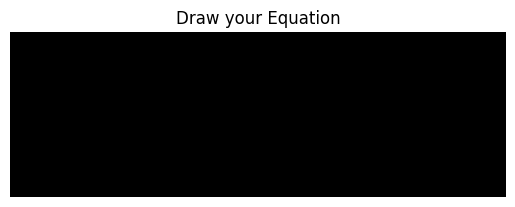

C:\Users\KIIT\AppData\Local\Temp\ipykernel_33852\3503265715.py:50: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  canvas_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


ValueError: cannot reshape array of size 319815 into shape (480,640,3)

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import base64
from io import BytesIO
from PIL import Image, ImageOps

# Create a blank canvas for drawing
canvas_size = (200, 600)  # Height, Width
canvas = np.ones(canvas_size) * 255  # White background

fig, ax = plt.subplots()
ax.imshow(canvas, cmap='gray')
ax.set_title("Draw your Equation")
ax.axis('off')

# Variables to keep track of drawing
drawing = False
last_x, last_y = None, None

# Mouse event handlers for drawing
def on_press(event):
    global drawing, last_x, last_y
    if event.inaxes != ax:
        return
    drawing = True
    last_x, last_y = int(event.xdata), int(event.ydata)

def on_move(event):
    global last_x, last_y
    if drawing and event.inaxes == ax:
        x, y = int(event.xdata), int(event.ydata)
        ax.plot([last_x, x], [last_y, y], color='black', linewidth=3)
        last_x, last_y = x, y
        fig.canvas.draw()

def on_release(event):
    global drawing
    drawing = False

# Connecting the events
fig.canvas.mpl_connect('button_press_event', on_press)
fig.canvas.mpl_connect('motion_notify_event', on_move)
fig.canvas.mpl_connect('button_release_event', on_release)

# Show the canvas and wait for the drawing to complete
plt.show()

# Convert the canvas to a grayscale image and resize it as needed
canvas_img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
canvas_img = canvas_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
canvas_img = cv2.cvtColor(canvas_img, cv2.COLOR_RGB2GRAY)
canvas_img = cv2.resize(canvas_img, (600, 200))

# Invert and preprocess the image
canvas_img = Image.fromarray(canvas_img)
canvas_img = ImageOps.invert(canvas_img)
im_array = np.array(canvas_img)

# Apply thresholding and morphological operations
_, thresh = cv2.threshold(im_array, 127, 255, 0)
kernel = np.ones((3, 3), np.uint8)
thresh = cv2.dilate(thresh, kernel, iterations=1)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
thresh = thresh[10:, 10:]

# Show the processed thresholded image
plt.imshow(thresh, cmap='gray')
plt.title("Threshold Image")
plt.axis('off')
plt.show()

# Convert the thresholded image to base64
retval, buffer_img = cv2.imencode('.png', thresh)
data = base64.b64encode(buffer_img).decode('utf-8')
operation = BytesIO(base64.urlsafe_b64decode(data))

# Placeholder for your CNN model prediction
# operation = CNN.predict(operation) # Uncomment and modify if CNN model available
# print(eval(operation))  # Print the result if model is available


## Simple Polynomial Solving Code

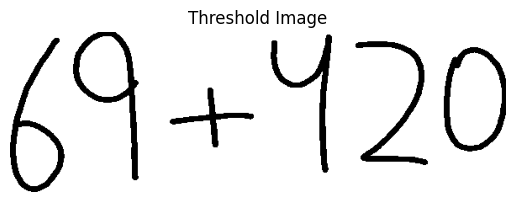

Loading Model...
Loading weights...
1/1 [==============================] - 0s 170ms/step
6
1/1 [==============================] - 0s 52ms/step
9
1/1 [==============================] - 0s 40ms/step
10
1/1 [==============================] - 0s 32ms/step
4
1/1 [==============================] - 0s 36ms/step
2
1/1 [==============================] - 0s 40ms/step
0
Operation is 69+420
489


In [6]:
#Importing the necessary Modules
# from google.colab.patches import cv2_imshow
import base64
from io import BytesIO
import cv2
im = cv2.imread("simp.png",0) # Read the User Image
im = cv2.resize(im,(600,200)) # Resize the User Image as per Model Requirement

# Thresholding the User Image 
#===============================
ret, thresh = cv2.threshold(im, 127, 255, 0)
kernel = np.zeros((3,3),np.uint8)
thresh = cv2.dilate(thresh,kernel,iterations = 1)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
thresh = thresh[10:,10:]
# cv2.imshow("Threshold", thresh)
plt.imshow(thresh, cmap='gray')
plt.title("Threshold Image")
plt.axis('off')
plt.show()
#===============================


# Conversion of the threshold image into base64 DataURL
# This is done as our model requires base64 string to detect Equation/Polynomial
#=================================================
retval, buffer_img= cv2.imencode('.png', thresh)
data = base64.b64encode(buffer_img)
data = str(data)
data = str(data)[2:len(data)-1]
operation = BytesIO(base64.urlsafe_b64decode(data))
#=================================================
#Initializing the CNN model
CNN = ConvolutionalNeuralNetwork()
operation = CNN.predict(operation) # Feeding the base64 string to the the CNN Model
print(eval(operation)) #print the result


## Linear Equation in One Variable

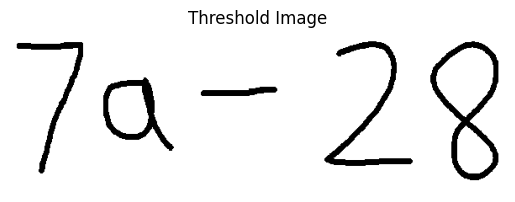

Loading Model...
Loading weights...
1/1 [==============================] - 0s 140ms/step
7
1/1 [==============================] - 0s 40ms/step
13
1/1 [==============================] - 0s 24ms/step
11
1/1 [==============================] - 0s 40ms/step
2
1/1 [==============================] - 0s 40ms/step
8
Operation is 7a-28
a = 4.0


In [7]:
# Function to solve Linear Equation in One Variable
def solveEquation(equation,variable) :

	n = len(equation)
	sign = 1
	coeff = 0
	total = 0
	i = 0

	for j in range(0, n) :
	
		if (equation[j] == '+' or
			equation[j] == '-') :
		
			if (j > i) :
				total = (total + sign *
						float(equation[i: j]))
			i = j

		elif (equation[j] == variable) :
		
			if ((i == j) or
				equation[j - 1] == '+') :
				coeff += sign
			elif (equation[j - 1] == '-') :
				coeff = coeff - sign
			else :
				coeff = (coeff + sign *
						float(equation[i: j]))
			i = j + 1
		

		elif (equation[j] == '=') :
		
			if (j > i) :
				total = (total + sign *
						float(equation[i: j]))
			sign = -1
			i = j + 1
		

	if (i < n) :
		total = (total + sign *
				float(equation[i: len(equation)]))


	if (coeff == 0 and
		total == 0) :
		return "Infinite solutions"


	if (coeff == 0 and total) :
		return "No solution"

	ans = -total / coeff
	return float(ans)


#Importing the necessary Modules
# from google.colab.patches import cv2_imshow
import base64
from io import BytesIO
import cv2
im = cv2.imread("lin.png",0) # Read the User Image
im = cv2.resize(im,(600,200)) # Resize the User Image as per Model Requirement

# Thresholding the User Image 
#===============================
ret, thresh = cv2.threshold(im, 127, 255, 0)
kernel = np.zeros((3,3),np.uint8)
thresh = cv2.dilate(thresh,kernel,iterations = 1)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
thresh = thresh[10:,10:]
# cv2.imshow("Threshold Image", thresh)
plt.imshow(thresh, cmap='gray')
plt.title("Threshold Image")
plt.axis('off')
plt.show()
#===============================


# Conversion of the threshold image into base64 DataURL
# This is done as our model requires base64 string to detect Equation/Polynomial
#=================================================
retval, buffer_img= cv2.imencode('.png', thresh)
data = base64.b64encode(buffer_img)
data = str(data)
data = str(data)[2:len(data)-1]
#=================================================
#Initializing the CNN model
operation = BytesIO(base64.urlsafe_b64decode(data))
CNN = ConvolutionalNeuralNetwork()
operation = CNN.predict(operation) # Feeding the base64 string to the the CNN Model
if 'a' in operation:
	print ("a = {}" .
        format(solveEquation(operation,'a'))) # Feeding the String output to the solveEquation Function to evaluate the value of variable a
if 'b' in operation:
	print ("b = {}" .
        format(solveEquation(operation,'b'))) # Feeding the String output to the solveEquation Function to evaluate the value of variable b




## Linear Equation in Two Variable

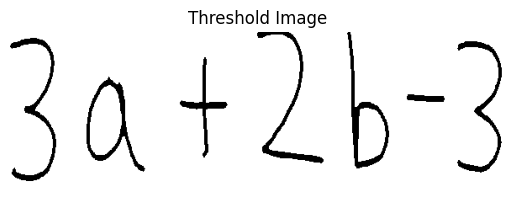

Loading Model...
Loading weights...
1/1 [==============================] - 0s 169ms/step
3
1/1 [==============================] - 0s 29ms/step
13
1/1 [==============================] - 0s 16ms/step
10
1/1 [==============================] - 0s 24ms/step
2
1/1 [==============================] - 0s 23ms/step
14
1/1 [==============================] - 0s 32ms/step
11
1/1 [==============================] - 0s 24ms/step
3
Operation is 3a+2b-3


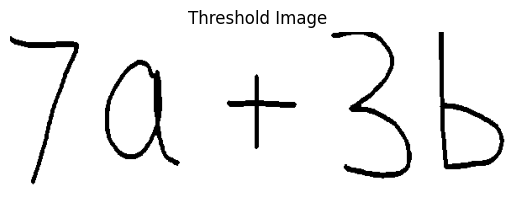

Loading Model...
Loading weights...
1/1 [==============================] - 0s 165ms/step
7
1/1 [==============================] - 0s 33ms/step
13
1/1 [==============================] - 0s 16ms/step
10
1/1 [==============================] - 0s 32ms/step
3
1/1 [==============================] - 0s 36ms/step
14
Operation is 7a+3b
Eq(3*a + 2*b - 3, 0)
Eq(7*a + 3*b, 0)


Values of the two unknown variables are as follows:
{a: -9/5, b: 21/5}


In [8]:
import re
from sympy.parsing.sympy_parser import parse_expr
from sympy import symbols, Eq, solve
import cv2
import numpy as np
import matplotlib.pyplot as plt
import base64
from io import BytesIO

ls = []
filenames = ["eq1.png", "eq2.png"]  # Filenames for the linear equations

# Function to clean the equation string from CNN output
def clean_equation(eq_str):
    # Example: Transform "3 a + 2 b - 3" to "3*a + 2*b - 3"
    eq_str = re.sub(r'(\d)\s*([a-zA-Z])', r'\1*\2', eq_str)
    return eq_str

for i in range(2):
    im = cv2.imread(filenames[i], 0)  # Read the image in grayscale
    im = cv2.resize(im, (600, 200))  # Resize image to model's requirement

    # Thresholding the image
    ret, thresh = cv2.threshold(im, 127, 255, 0)
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.dilate(thresh, kernel, iterations=1)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    thresh = thresh[10:, 10:]

    # Display the thresholded image
    plt.imshow(thresh, cmap='gray')
    plt.title("Threshold Image")
    plt.axis('off')
    plt.show()

    # Convert thresholded image to base64 data URL
    retval, buffer_img = cv2.imencode('.png', thresh)
    data = base64.b64encode(buffer_img).decode('utf-8')

    # Initialize and use the CNN model (assuming `ConvolutionalNeuralNetwork` is defined)
    operation = BytesIO(base64.urlsafe_b64decode(data))
    CNN = ConvolutionalNeuralNetwork()  # Ensure this class is implemented
    operation = CNN.predict(operation)

    # Clean and store the operation
    cleaned_operation = clean_equation(operation)
    ls.append(cleaned_operation)

# Assign equations and define symbols
eq1_str, eq2_str = ls[0], ls[1]
x, y = symbols('a b')  # Define the symbols used in equations

# Parse the cleaned equations
eq1 = Eq(parse_expr(eq1_str), 0)
eq2 = Eq(parse_expr(eq2_str), 0)

# Print the equations for verification
print(eq1)
print(eq2)

# Solve the equations for x and y
print("\n\nValues of the two unknown variables are as follows:")
print(solve((eq1, eq2), (x, y)))
